================================= Author: Arman Javan Sekhavat =================================


In this notebook, a test trajectory is generated in the Cartesian space
and the manipulator's motion is controlled by the TJ (Transpose Jacobian)
method to follow this trajectory. To assess the controller's performance,
actual end-effector position is compared with its desired value along the
entire trajectory.

In [1]:
# Standard modules
import mujoco
import numpy as np
from mujoco import viewer
import matplotlib.pyplot as plt

In [2]:
# Custom modules
import ForwardKinematics
import TrajectoryGeneration

In [3]:
m = mujoco.MjModel.from_xml_path("Robotic_Arm_DirectDrive.xml")
d = mujoco.MjData(m)

In [4]:
duration = 10.0 # Seconds

Kp = np.diag([15.0, 15.0, 20.0, 0.0, 0.0, 0.0]) # Position gain matrix
Kv = 2*np.sqrt(Kp) # Velocity gain matrix

In [5]:
mujoco.mj_resetData(m, d)

X_d_list = [] # Desired end-effector positions
X_list = [] # Actual end-effector positions
t = [] # Simulation time

viewer_obj = mujoco.viewer.launch_passive(m, d)

while d.time < duration:

    # Desired values
    # A circular path is generated as the desired trajectory
    X_d, X_dot_d, X_ddot_d = TrajectoryGeneration.CartesianPath(d.time)

    # Actual values
    q = np.array(d.qpos[0:6])
    q_dot = np.array(d.qvel[0:6])
    Jacobian = ForwardKinematics.Jacobian_jit(q)
    
    X = ForwardKinematics.EEpos_jit(q)
    X_dot = (Jacobian@q_dot)[0:3]


    # Recording values
    X_d_list.append(X_d)
    X_list.append(X)
    t.append(d.time)

    # Error signal
    E = X_d - X
    E_dot = X_dot_d - X_dot

    E = np.hstack([E, np.zeros(shape = (3,))])
    E_dot = np.hstack([E_dot, d.sensordata[19:22]])
    X_ddot_d = np.hstack([X_ddot_d, np.zeros(shape = (3,))])

    # Feedback control law
    d.ctrl = np.transpose(ForwardKinematics.Jacobian_jit(q))@(X_ddot_d + Kv@E_dot + Kp@E)


    mujoco.mj_step(m, d)
    viewer_obj.sync()

viewer_obj.close()

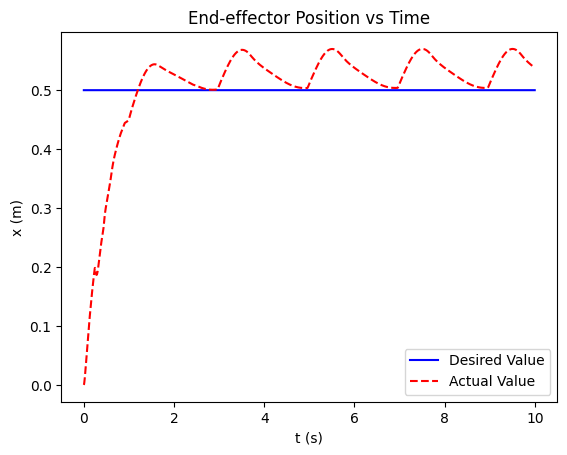

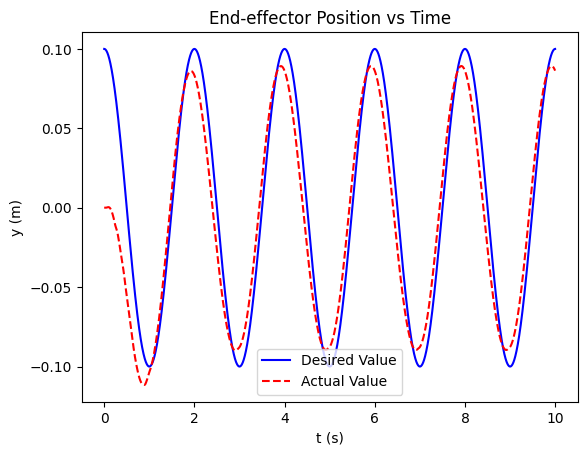

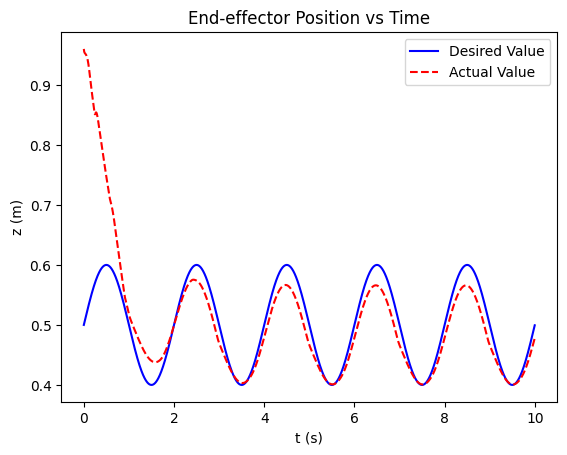

In [6]:
X_d_list = np.array(X_d_list)
X_list = np.array(X_list)
t = np.array(t)


plt.figure()
plt.plot(t, X_d_list[:, 0], label = "Desired Value", linestyle = "solid", color = "blue")
plt.plot(t, X_list[:, 0], label = "Actual Value", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("x (m)")
plt.title("End-effector Position vs Time")
plt.show()

plt.figure()
plt.plot(t, X_d_list[:, 1], label = "Desired Value", linestyle = "solid", color = "blue")
plt.plot(t, X_list[:, 1], label = "Actual Value", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("y (m)")
plt.title("End-effector Position vs Time")
plt.show()


plt.figure()
plt.plot(t, X_d_list[:, 2], label = "Desired Value", linestyle = "solid", color = "blue")
plt.plot(t, X_list[:, 2], label = "Actual Value", linestyle = "dashed", color = "red")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("z (m)")
plt.title("End-effector Position vs Time")
plt.show()
